In [1]:
train_dir_LandSAT = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Landsat 30m Resolution"
train_dir_Sentinel = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Sentinel uint16 Data 0%water and 0%land exclude"
save_last = r"C:\Saiful_Results\UNET_MC_2_Base_Full"


In [2]:
import time

today=str(time.ctime().replace(":","-").replace(" ","-"))
print(today)

save_last = save_last+"\\"+today
    
print(save_last)

Thu-Apr-27-12-27-12-2023
C:\Saiful_Results\UNET_MC_2_Base_Full\Thu-Apr-27-12-27-12-2023


In [3]:
import os



if not os.path.exists(save_last):
    os.makedirs(save_last) 
    
    
    

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# import os
import copy
import sys
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
from collections import OrderedDict
import pandas as pd
from tqdm import tqdm
import random
from collections import defaultdict 
import tifffile as tiff
import imageio as io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import segmentation_models_pytorch as smp
from skimage.morphology import binary_dilation, binary_erosion
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import average_precision_score

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Loss Functions

In [6]:
def weighted_bce_loss(output,y,weight):
    epsilon= 1e-7
    output = torch.clamp(output, epsilon, 1.-epsilon)
    logit_output = torch.log(output/(1.-output))
    
    loss = (1.-y)*logit_output + (1.+(weight-1.)*y) * (torch.log(1.+torch.exp(-torch.abs(logit_output))) + torch.maximum(-logit_output,torch.tensor(0.).cuda()))
    return torch.sum(loss)/torch.sum(weight)

def weighted_dice_loss(output,y,weight):
    smooth = 1.
    w,m1,m2 = weight*weight, y, output
    intersection = (m1*m2)
    score = (2.*torch.sum(w*intersection)+smooth)/(torch.sum(w*m1)+torch.sum(w*m2)+smooth)
    loss  = 1.-torch.sum(score)
    return loss

def iou_loss(y_pred, y_true, weight):
    weight = weight*weight
    intersection = y_true * y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou          = (torch.sum(intersection * weight)) / (torch.sum(union * weight))

    loss = 1-iou
    return loss
    

def border_loss(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

# Functions

In [7]:
################ Metrics #######################
def IoU_pr_rec_f1(y_true, y_pred):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    y_pred = ((y_pred)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = (tp/(tp+fp))
    rec = (tp/(tp+fn))
    f1  = ((2*pr*rec)/(pr+rec))
    tnr = (tn/(tn+fp))
    fpr = (fp/(fp+tn))
    
    intersection = y_true*y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou         = (torch.sum(intersection)) / (torch.sum(union))
    
    return iou, pr, rec, f1, tnr, fpr

# Saving Metrics
def metrics():
    x = np.arange(0,1,0.05)
    IoU_      = []
    threshold = []
    precision = []
    recall    = []
    F_score   = []
    mF_score  = []
    TNR       = []
    FPR       = []
    name_list = []

    dict_1 = {'Threshold': threshold,
              'Name':name_list,
              'IoU':IoU_,
              'Precision':precision,
              'Recall':recall,
              'F-Score':F_score,
              'mF-Score':mF_score,
              'True Negative Rate':TNR,
              'False Positive Rate':FPR}
    return dict_1

def best_f_score(name, test_masks, predictions) :
    dict_1 = metrics()
    y = 0
    outer = 0
    check = 0
    x = 0 
    y = 1
    while outer<3:    
        if y>1:
            m = y-1
            y-= m
        z = np.linspace(x, y, 21)
        for i in z:
#             print(i)
            y_true = torch.from_numpy(test_masks)
            y_pred = torch.from_numpy((predictions>i)*1)

            tp = torch.sum(y_true*(y_pred),dim=[1,2,3])
            tn = torch.sum((1-y_true)*((1-y_pred)),dim=[1,2,3])
            fp = torch.sum((1-y_true)*(y_pred),dim=[1,2,3])
            fn = torch.sum((y_true)*((1-y_pred)),dim=[1,2,3])

            pr  = (tp/(tp+fp))
            rec = (tp/(tp+fn))
            score  = ((2*pr*rec)/(pr+rec))
            idx    = torch.isnan(score)
            score[idx] = 0
            score  = torch.sum(score)/len(X_test)
            
            a,b,c,d,e,f = IoU_pr_rec_f1(torch.from_numpy(test_masks), torch.from_numpy(predictions>i))
            dict_1['IoU'].append(a.numpy())
            dict_1['Threshold'].append(i)
            dict_1['Precision'].append(b.numpy())
            dict_1['Recall'].append(c.numpy())
            dict_1['F-Score'].append(d.numpy())
            dict_1['mF-Score'].append(score.cpu().detach().numpy())
            dict_1['True Negative Rate'].append(e.numpy())
            dict_1['False Positive Rate'].append(f.numpy())
            dict_1['Name'].append(name)
            if d>check:
                check = d
                x = i
            else:
                pass
        if outer == 0:
            y = x+0.1
        elif outer==1:
            y = x+0.01
        outer+=1
    
    df = pd.DataFrame(dict_1)
    df = df.sort_values(by=['F-Score'], ascending=False)
    df = df.iloc[0:1]
    
    AP = average_precision_score(test_masks.reshape(-1), predictions.reshape(-1))
    df['AP'] = AP
        
    return df

dict_1 = metrics()

# Load Labeled Data

In [8]:
X_train_LandSAT = np.load(r"{}\X_train_4500_30m_res.npy".format(train_dir_LandSAT))
X_val_LandSAT   = np.load(r"{}\X_val_500_30m_res.npy".format(train_dir_LandSAT))
X_test_LandSAT  = np.load(r"{}\X_test_2000_30m_res.npy".format(train_dir_LandSAT))

Y_train_LandSAT = (X_train_LandSAT[...,1]-X_train_LandSAT[...,3])/(X_train_LandSAT[...,1]+X_train_LandSAT[...,3])
Y_val_LandSAT   = (X_val_LandSAT[...,1]-X_val_LandSAT[...,3])/(X_val_LandSAT[...,1]+X_val_LandSAT[...,3])
Y_test_LandSAT  = (X_test_LandSAT[...,1]-X_test_LandSAT[...,3])/(X_test_LandSAT[...,1]+X_test_LandSAT[...,3])

Y_train_LandSAT = ((Y_train_LandSAT<1.)*1).astype('float32')
Y_val_LandSAT   = ((Y_val_LandSAT<1.)*1).astype('float32')
Y_test_LandSAT  = ((Y_test_LandSAT<1.)*1).astype('float32')

X_train_LandSAT = X_train_LandSAT[...,2::-1].copy()
X_val_LandSAT   = X_val_LandSAT[...,2::-1].copy()
X_test_LandSAT  = X_test_LandSAT[...,2::-1].copy()

X_train_LandSAT = X_train_LandSAT - X_train_LandSAT.min(axis=(1,2), keepdims=True) 
X_val_LandSAT   = X_val_LandSAT  - X_val_LandSAT.min(axis=(1,2), keepdims=True)
X_test_LandSAT  = X_test_LandSAT - X_test_LandSAT.min(axis=(1,2), keepdims=True) 

X_train_LandSAT = X_train_LandSAT / X_train_LandSAT.max(axis=(1,2), keepdims=True) 
X_val_LandSAT   = X_val_LandSAT  / X_val_LandSAT.max(axis=(1,2), keepdims=True)
X_test_LandSAT  = X_test_LandSAT / X_test_LandSAT.max(axis=(1,2), keepdims=True) 

C:\Users\HPCL\AppData\Local\Temp\ipykernel_4076\3036067045.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train_LandSAT = (X_train_LandSAT[...,1]-X_train_LandSAT[...,3])/(X_train_LandSAT[...,1]+X_train_LandSAT[...,3])
C:\Users\HPCL\AppData\Local\Temp\ipykernel_4076\3036067045.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test_LandSAT  = (X_test_LandSAT[...,1]-X_test_LandSAT[...,3])/(X_test_LandSAT[...,1]+X_test_LandSAT[...,3])


In [9]:
## SENTINEL DATA

In [10]:
np.random.seed(49)
pop = np.arange(5121)
sample_train = np.random.choice(pop, 4608, replace=False)
sample_val  = np.delete(pop, sample_train)
len(sample_train), len(sample_val)

(4608, 513)

In [11]:
X_sen      = np.load(r"{}\X_train_sentinel_6_channles_5121.npy".format(train_dir_Sentinel))
X_test_sen = np.load(r"{}\X_test_sentinel_6_channles_2053.npy".format(train_dir_Sentinel))
X_train_sen= X_sen[sample_train]
X_val_sen  = X_sen[sample_val]

Y_train_sen         = (X_train_sen[...,1]-X_train_sen[...,3])/(X_train_sen[...,1]+X_train_sen[...,3])
Y_val_sen           = (X_val_sen[...,1]-X_val_sen[...,3])/(X_val_sen[...,1]+X_val_sen[...,3])
Y_test_sen         = (X_test_sen[...,1]-X_test_sen[...,3])/(X_test_sen[...,1]+X_test_sen[...,3])

Y_train_sen         = ((Y_train_sen<1.)*1).astype('float32')
Y_val_sen           = ((Y_val_sen<1.)*1).astype('float32')
Y_test_sen          = ((Y_test_sen<1.)*1).astype('float32')

X_train_sen         = X_train_sen[...,2::-1].copy()
X_val_sen           = X_val_sen[...,2::-1].copy()
X_test_sen          = X_test_sen[...,2::-1].copy()

X_train_sen         = np.clip(X_train_sen, 0, 3558) 
X_val_sen           = np.clip(X_val_sen, 0, 3558)
X_test_sen          = np.clip(X_test_sen, 0, 3558) 

X_train_sen         = (X_train_sen / 3558).astype(np.float32) 
X_val_sen           = (X_val_sen  / 3558).astype(np.float32)
X_test_sen          = (X_test_sen / 3558).astype(np.float32) 

Y_train_sen.shape

(4608, 128, 128)

In [12]:
Y_test= Y_test_sen # np.concatenate((Y_test_LandSAT,Y_test_sen),axis = 0)
Y_test.shape

(2053, 128, 128)

In [13]:
# Contours for Sentinel


Y_train_sen_ndwi = np.array([mask for mask in Y_train_sen], dtype='float64')

Y_val_sen_ndwi = np.array([mask for mask in Y_val_sen], dtype='float64')

Y_test_sen_ndwi = np.array([mask for mask in Y_test_sen], dtype='float64')

In [14]:
Y_test_sen_ndwi.shape


(2053, 128, 128)

b = np.zeros((yyyy.size, yyyy.max() + 1.0))
b[np.arange(yyyy.size), yyyy] = 1.0


In [15]:
Y_train_sen  = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_train_sen], dtype='float64')
Y_val_sen   = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_val_sen], dtype='float64')
Y_test_sen  = np.array([binary_dilation(binary_dilation(mask))-mask for mask in Y_test_sen], dtype='float64')

In [16]:
Y_train_sen = Y_train_sen + 2*(Y_train_sen_ndwi)

In [17]:
Y_train_sen[Y_train_sen<2]

array([0., 0., 0., ..., 0., 1., 1.])

In [18]:
Y_train_sen.shape

(4608, 128, 128)

In [19]:
def createOneHotKey(original,ndwi):
    combined = original + 2 * ndwi
    
    land = np.where(combined == 0, 1.0, 0.0)
    contour = np.where(combined==1,1.0,0.0)
    water= np.where(combined==2,1.0,0.0)
    
    one_hot_label = np.concatenate((combined[...,np.newaxis], land[...,np.newaxis]), axis=3)
    one_hot_label = np.concatenate((one_hot_label, contour[...,np.newaxis]), axis=3)
    one_hot_label = np.concatenate((one_hot_label, water[...,np.newaxis]), axis=3)
    one_hot_label = one_hot_label[...,1:4]
    
    print(one_hot_label.shape)
    return one_hot_label

In [20]:
Y_train_sen = createOneHotKey(Y_train_sen,Y_train_sen_ndwi)

Y_val_sen = createOneHotKey(Y_val_sen,Y_val_sen_ndwi)

Y_test_sen = createOneHotKey(Y_test_sen,Y_test_sen_ndwi)

(4608, 128, 128, 3)
(513, 128, 128, 3)
(2053, 128, 128, 3)


In [21]:
from sklearn.utils import shuffle
X_sen, Y_sen = shuffle(X_train_sen, Y_train_sen, random_state=0)

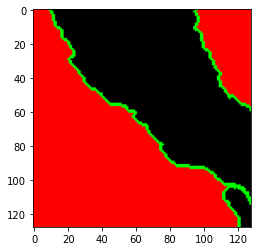

In [22]:
plt.imshow(Y_sen[0])

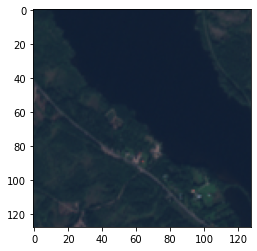

In [23]:
plt.imshow(X_sen[0])

In [24]:
# Contours for LandSAT

In [25]:
Y_train_LandSAT_ndwi  = np.array([mask for mask in Y_train_LandSAT], dtype='float64')
Y_val_LandSAT_ndwi   = np.array([mask for mask in Y_val_LandSAT], dtype='float64')
Y_test_LandSAT_ndwi  = np.array([mask for mask in Y_test_LandSAT], dtype='float64')

In [26]:
Y_train_LandSAT  = np.array([binary_dilation(mask)-mask for mask in Y_train_LandSAT], dtype='float64')
Y_val_LandSAT   = np.array([binary_dilation(mask)-mask for mask in Y_val_LandSAT], dtype='float64')
Y_test_LandSAT  = np.array([binary_dilation(mask)-mask for mask in Y_test_LandSAT], dtype='float64')

In [27]:
Y_train_LandSAT = createOneHotKey(Y_train_LandSAT,Y_train_LandSAT_ndwi)

Y_val_LandSAT = createOneHotKey(Y_val_LandSAT,Y_val_LandSAT_ndwi)

Y_test_LandSAT = createOneHotKey(Y_test_LandSAT,Y_test_LandSAT_ndwi)

(4500, 128, 128, 3)
(500, 128, 128, 3)
(2000, 128, 128, 3)


In [28]:
X_LS, Y_LS = shuffle(X_train_LandSAT, Y_train_LandSAT, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


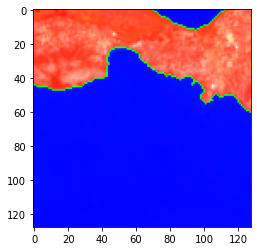

In [29]:
plt.imshow(X_LS[0]+Y_LS[0])

In [30]:
# Concatenate the inputs and labels#

In [31]:
X_train = np.concatenate((X_LS,X_sen),axis = 0)
print(X_train.shape)

X_val = np.concatenate((X_val_LandSAT,X_val_sen),axis = 0)
print(X_val.shape)

X_test = np.concatenate((X_test_LandSAT,X_test_sen),axis = 0)
print(X_test.shape)

(9108, 128, 128, 3)
(1013, 128, 128, 3)
(4053, 128, 128, 3)


In [32]:
Y_train=  np.concatenate((Y_LS,Y_sen),axis = 0)
print(Y_train.shape)

Y_val=  np.concatenate((Y_val_LandSAT,Y_val_sen),axis = 0)
print(Y_val.shape)

Y_test=  np.concatenate((Y_test_LandSAT,Y_test_sen),axis = 0)
print(Y_test.shape)

(9108, 128, 128, 3)
(1013, 128, 128, 3)
(4053, 128, 128, 3)


In [33]:
# shuffle the training data

In [34]:
X, Y = shuffle(X_train, Y_train, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


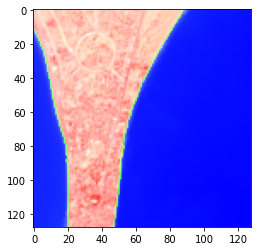

In [35]:
plt.imshow(X[0]+Y[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


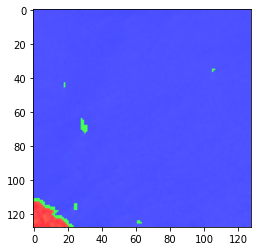

In [36]:
plt.imshow(X_val[1002]+Y_val[1002])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


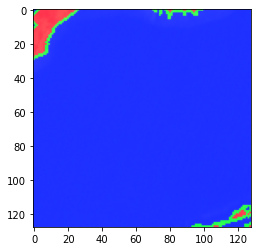

In [37]:
plt.imshow(X_test[4002]+Y_test[4002])

# Pytorch DataLoaders

In [38]:
class NDWIDataset_pseudo(Dataset):

    def __init__(self, imgs, model_pred, threshold=None, transform=None, test_transform=None):
        self.image   = imgs
        self.model   = model_pred
        self.transforms = transform
        self.threshold  = threshold

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        image = self.image[idx].astype('float32')
        model = self.model
        image= image[...,2::-1].copy()
        image= image - image.min(axis=(0,1))
        image= image / image.max(axis=(0,1))
        
        if self.transforms:
            augmentations = self.transforms(image=image)
        
        image = augmentations['image']
        mask  = ((model(image[np.newaxis].cuda()).cpu().detach())>self.threshold)*1.
        mask  = mask.squeeze()
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]
        

In [39]:
class NDWIDataset_from_dir(Dataset):

    def __init__(self, img_dir, model_pred, threshold=None, transform=None, test_transform=None):
        self.dir     = img_dir
        self.model   = model_pred
        self.transforms = transform
        self.threshold  = threshold

    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, idx):
        path = self.dir[idx]
        model = self.model
        image= (tiff.imread(path)).astype('float32')
        image= image[...,2::-1].copy()
        image= image - image.min(axis=(0,1))
        image= image / image.max(axis=(0,1))
        
        if self.transforms:
            augmentations = self.transforms(image=image)
        
        image = augmentations['image']
        mask  = ((model(image[np.newaxis].cuda()).cpu().detach())>self.threshold)*1.
        mask  = mask.squeeze()
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]

In [40]:
class NDWIDataset_from_dir_reg(Dataset):

    def __init__(self, img_dir, transform=None, test_transform=None):
        self.dir     = img_dir
        self.transforms = transform

    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, idx):
        eps  = 1e-7
        path = self.dir[idx]
        image= (tiff.imread(path)).astype('float32')
        mask = (((image[...,1]-image[...,3] +eps)/(image[...,1]+image[...,3] +eps))>0).astype('float32')
        mask = binary_dilation(mask)-mask
        
        image= image[...,2::-1].copy()
        image= (image) - (image.min(axis=(0,1)))
        image= (image+eps) / (image.max(axis=(0,1))+eps)
        
        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask = augmentations['mask']
        mask = mask[np.newaxis,:,:]
        
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]        

In [41]:
class NDWIDataset(Dataset):

    def __init__(self, images, masks, transform=None, test_transform=None):
        self.images     = images
        self.masks      = masks
        self.transforms = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask  = augmentations['mask']
#         mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32).permute(2,0,1)]
        

In [42]:
def data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, split=0.9, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset= NDWIDataset(X_train, Y_train, transform=trans)

    if val:
        print(f'Training:{len(X_train)}, Validation:{len(X_val)}')
        print(f'Testing: {len(X_test)}')
        
        valset  = NDWIDataset(X_val, Y_val, transform=trans_test)
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    else:
        print(f'Training:{len(X_train)}')
        print(f'Testing: {len(X_test)}')
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [43]:
def data_from_dir_reg(trans, trans_test, list_train, list_val, list_test, split=0.9, factor=1, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset = NDWIDataset_from_dir_reg(list_train, transform=trans)

    if val:
#         lengths = [int(len(dataset)*split), int(len(dataset)*(1-split))+factor]
        
        valset  = NDWIDataset_from_dir_reg(list_val, transform=trans)
        testset = NDWIDataset_from_dir_reg(list_test, transform=trans_test)
        print(f'Training:{len(list_train)}, Validation:{len(list_val)}')
        print(f'Testing: {len(list_test)}')
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    else:
        lengths = [int(len(dataset))]
        print(f'Training:{len(list_train)}')
        print(f'Testing: {len(list_test)}')
        testset = NDWIDataset_from_dir_reg(list_test, transform=trans_test)
        image_datasets = {'train': dataset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [44]:
def data_pseudo(trans, img_paths, model, batch_size=32, split=None):
    torch.manual_seed(49)
    random.seed(49)
    if split==None:
        dataset = NDWIDataset_from_dir(img_paths, model, transform=trans)
        lengths = [int(len(dataset))]
        print(f'Pseudo-Training:{lengths[0]}')
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory = True)#, num_workers=8)
    else:
        dataset = NDWIDataset_from_dir(img_paths, model, transform=trans)
        lengths = [int(len(dataset)*split), int(len(dataset)*(1-split))+1]
        trainset, valset = torch.utils.data.random_split(dataset, lengths)
        
        print(f'Pseudo-Training, Train: {len(trainset)}, Validation: {len(valset)}')
        dataloader = {'train':DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),
                      'val'  :DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True)}

    
    return dataloader

In [45]:
trans = A.Compose([
#     A.RandomCrop(128,128),
#     A.VerticalFlip(),
#     A.HorizontalFlip(),
    ToTensorV2()])
trans_test = A.Compose([
#              A.RandomCrop(128,128),
             ToTensorV2()])

In [46]:
def plot_rand(dataloader, set_='train'):
    if set_==None:
        for x,y in dataloader:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    else:
        for x,y in dataloader[set_]:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    rand = np.random.randint(0,x.shape[0])
    plt.subplot(121)
    plt.imshow(x[rand])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(y[rand])
    plt.title('Contour')
    plt.axis('off')
    plt.show()
#     return x,y

In [47]:
# dataloaders  = data_from_dir_reg(trans, trans_test, list_train, list_val, list_test, split=0.9)
# # dataloader_p = data_pseudo(trans, list_paths, model_pred)

# Evaluation Metrics

In [48]:
def f1_score(y_pred, y_true, threshold=0.5):
    
#     y_true = y_true.view(-1)
#     y_pred = y_pred.view(-1)
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    
    
    y_pred = ((y_pred>threshold)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = ((tp+1.)/(tp+fp+1.))
    rec = ((tp+1.)/(tp+fn+1.))
    f1  = ((2*pr*rec)/(pr+rec))
    return f1

 Exponential MA = $V_{t} = \beta V_{t-1} + (1-\beta)(current)$

In [49]:
class basic_block(nn.Module):
#    def __init__(self,in_channels,out_channels, random_state=0):
    def __init__(self,in_channels,out_chan, random_state=0):
        super(basic_block,self).__init__()
        
        #out_channels = out_chan
        out_channels = out_chan//2
        
        torch.manual_seed(random_state)
        self.bn1         = nn.BatchNorm2d(in_channels)
        
        self.conv1x1_1_1 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn2         = nn.BatchNorm2d(out_channels)
        
        self.conv1x1_1_3 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn3         = nn.BatchNorm2d(out_channels)
        
        self.conv3x3_1   = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn4         = nn.BatchNorm2d(out_channels)
        
        self.conv1x1_1_5 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn5         = nn.BatchNorm2d(out_channels)
        
        self.conv5x5_1   = nn.Conv2d(out_channels,out_channels,5,padding=2)
        self.bn6         = nn.BatchNorm2d(out_channels)
        
        self.conv1x1_1_7 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn7         = nn.BatchNorm2d(out_channels)
        
        self.conv7x7_1   = nn.Conv2d(out_channels,out_channels,7,padding=3)
        self.bn8         = nn.BatchNorm2d(out_channels)
        
        self.bn9         = nn.BatchNorm2d(out_channels*4)
        self.conv1x1_2_1 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn10        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_3 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn11        = nn.BatchNorm2d(out_channels)
        self.conv3x3_2   = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn12        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_5 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn13        = nn.BatchNorm2d(out_channels)
        self.conv5x5_2   = nn.Conv2d(out_channels,out_channels,5,padding=2)
        self.bn14        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_7 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn15        = nn.BatchNorm2d(out_channels)
        self.conv7x7_2   = nn.Conv2d(out_channels,out_channels,7,padding=3)
        self.bn16        = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        
        bn1         = self.bn1(x)
        conv1x1_1_3 = self.bn3(self.conv1x1_1_3(bn1))
        conv1x1_1_5 = self.bn4(self.conv1x1_1_5(bn1))
        conv1x1_1_7 = self.bn5(self.conv1x1_1_7(bn1))
        conv1x1_1_1 = F.relu(self.bn2(self.conv1x1_1_1(bn1)))
        conv3x3_1   = F.relu(self.bn6(self.conv3x3_1(conv1x1_1_3)))
        conv5x5_1   = F.relu(self.bn7(self.conv5x5_1(conv1x1_1_5)))
        conv7x7_1   = F.relu(self.bn8(self.conv7x7_1(conv1x1_1_7)))
        cat1        = torch.cat([conv1x1_1_1,conv3x3_1,conv5x5_1,conv7x7_1],dim=1)
        
        bn9         = self.bn9(cat1)
        conv1x1_2_3 = self.bn11(self.conv1x1_2_3(bn9))
        conv1x1_2_5 = self.bn12(self.conv1x1_2_5(bn9))
        conv1x1_2_7 = self.bn13(self.conv1x1_2_7(bn9))
        conv1x1_2_1 = F.relu(self.bn10(self.conv1x1_2_1(bn9)))
        conv3x3_2   = F.relu(self.bn14(self.conv3x3_2(conv1x1_2_3)))
        conv5x5_2   = F.relu(self.bn15(self.conv5x5_2(conv1x1_2_5)))
        conv7x7_2   = F.relu(self.bn16(self.conv7x7_2(conv1x1_2_7)))
        cat2        = torch.cat([conv1x1_2_1,conv3x3_2,conv5x5_2,conv7x7_2],dim=1)

  
        return cat2
        

class UNET_multiscale2(nn.Module):
###    def __init__(self, in_channels=3, out_channels= 1, init_features=16, random_state=0):
    def __init__(self, in_channels=3, out_channels= 1, init_features=32, random_state=0):
        super(UNET_multiscale2, self).__init__()
        torch.manual_seed(random_state)
        features = init_features
        self.layer1 =  basic_block(3,features)
        self.down1  = nn.Conv2d(features*2,features,2,stride=2)
        
        self.layer2 = basic_block(features,features) 
        self.down2  = nn.Conv2d(features*2,features*2,2,stride=2)

        self.layer3 = basic_block(features*2,features*2) 
        self.down3  = nn.Conv2d(features*4,features*4,2,stride=2)

        self.layer4 = basic_block(features*4,features*4)
        self.down4  = nn.Conv2d(features*8,features*8,2,stride=2)
        
        self.bottleneck = basic_block(features*8,features*8)
        self.bn6     = nn.BatchNorm2d(features*8*2)
        self.up1     = nn.ConvTranspose2d(features*16, features*8, 2, stride=2)
               
        self.layer6  = basic_block(features*16,features*4)      
        self.bn7     = nn.BatchNorm2d(features*4*2)
        self.up2     = nn.ConvTranspose2d(features*8, features*4, 2, stride=2)

        self.layer7  = basic_block(features*8,features*2) 
        self.bn8     = nn.BatchNorm2d(features*2*2)
        self.up3     = nn.ConvTranspose2d(features*4, features*2, 2, stride=2)   
        
        self.layer8  = basic_block(features*4,features) 
        self.bn9     = nn.BatchNorm2d(features*2)
        self.up4     = nn.ConvTranspose2d(features*2, features*2, 2, stride=2)
        
        self.layer9  = basic_block(features*4,features)
        self.out     = nn.Conv2d(features*2, 3, 1)
        
    def forward(self, x):
        
        layer1 = self.layer1(x)
        down1  = F.relu(self.down1(layer1))

        layer2 = self.layer2(down1) 
        down2  = F.relu(self.down2(layer2))
        
        layer3 = self.layer3(down2) 
        down3  = F.relu(self.down3(layer3))
        
        layer4 = self.layer4(down3) 
        down4  = F.relu(self.down4(layer4))

        
        bottleneck = self.bottleneck(down4)
        up1     = F.relu(self.up1(self.bn6(bottleneck), output_size=layer4.size()))

        merge1  = torch.cat([up1, layer4], dim=1)      
        layer6  = self.layer6(merge1)
        up2        = F.relu(self.up2(self.bn7(layer6), output_size=layer3.size()))

        merge2     = torch.cat([up2, layer3], dim=1)
        layer7     = self.layer7(merge2)
        up3        = F.relu(self.up3(self.bn8(layer7), output_size=layer2.size()))

        merge3     = torch.cat([up3, layer2], dim=1)
        layer8  = self.layer8(merge3)
        up4        = F.relu(self.up4(self.bn9(layer8), output_size=layer1.size()))
        
        merge4     = torch.cat([up4, layer1], dim=1)
        layer9  = self.layer9(merge4)               
        
        m = torch.nn.Softmax(dim=1)
        
        out        = m(self.out(layer9))
                        
        return out



In [50]:
import time
def train_round1(model, dataloaders, loss_fn, optimizer, acc_fn, random_state=49, epochs=1):
    
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(False)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    counter=0
    train_loss, valid_loss = [], []                            #Running training and validation loss
    val_epoch, f1_epoch = [0],[0]
    loss_list = []
    times     = []
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch}')
        print(scheduler.get_last_lr())
    

    #########################################Begin Model Training######################################################
    ###################################################################################################################
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()                             # Set training mode all the layers including batchnorm and dropout work in this
                dataloader = dataloaders['train']         #get the training data
            else:
                model.eval()                              # Set model to evaluate mode deactivates the batchnorm and dropout layers
                dataloader = dataloaders['val']           #get the validation data

            running_loss = 0.0                            #running loss to be used for visualization later
            step = 0                                      #Batch number
            
            if phase == 'train':  
                f1 = []
                AP = []
                for inputs, labels in dataloader:
                    x, y = inputs.to(device), labels.to(device)
                    step += 1

                    optimizer.zero_grad()                                   # zero the gradients
                    outputs = model(x)                                      #get model output for a given input

#                     print("outputs",outputs[:,1:2,...].shape)
                    #################Metrics###################
                    f1.append(acc_fn(outputs[:,1:2,...], y[:,1:2,...]).cpu().detach().numpy())
                    AP.append(average_precision_score(y[:,1:2,...].reshape(-1).cpu().detach().numpy(),  outputs[:,1:2,...].reshape(-1).cpu().detach().numpy()))

                    ############################################

                    ##################Calculate Loss, backprop, and update###############
#                     loss           = loss_fn(outputs, y)
#                     print("x",x.shape)
#                     print("y",y.shape)
#                     m = torch.nn.CrossEntropyLoss()
    
#                     loss = crossE_Loss(outputs, y)
        
                    B,C,H,W = y.shape
        
                    ysum_zeros = y.sum(axis=(2,3))
#                     print("ysum_zeros",ysum_zeros)
                
                    minimals =  0.000001* torch.ones_like(ysum_zeros)
#                     print("minimals",minimals)
                    
            
                    ysum = torch.where(ysum_zeros > 0.0, ysum_zeros.float(),minimals)
                
#                     torch.where(x > 0, x, y)

                
#                     print("y.sum",ysum)

                    weights = H*W/ysum
                    
                    

                    
                    
#                     print("weights",weights)
                    weights /= weights.sum(axis=1).reshape(B,1)
#                     print("weightsNormalized",weights)
                    ce = -torch.log(outputs+0.000001)*y*weights.reshape(B,C,1,1)
                    loss = ce.sum()/B/W/H
                    
#                     print("ce",ce)
                    
                    
                    train_loss.append(loss.cpu().detach().numpy())
                    loss.backward()
                    optimizer.step()
                    print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}', end='\r') 
                    ######################################################################
                    
#                 print("outputs",outputs[:,1:2,...].shape)
#                 print("y",y[:,1:2,...].shape)
                print()
            else:  
                loss_val = []
                f1=[]
                AP = []
                with torch.no_grad():
                    for inputs, labels in dataloader:
                        x, y = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()                                   # zero the gradients
                        outputs = model(x)                                      #get model output for a given input

                        #################Metrics###################
                        f1.append(acc_fn(outputs[:,1:2,...], y[:,1:2,...]).cpu().detach().numpy())
#                         AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))
                        AP.append(average_precision_score(y[:,1:2,...].reshape(-1).cpu().detach().numpy(),  outputs[:,1:2,...].reshape(-1).cpu().detach().numpy()))

                    ############################################

                        ##################Calculate Loss, backprop, and update###############
        
#                         loss = torch.nn.CrossEntropyLoss(outputs, y)
#                         loss           = loss_fn(outputs, y)
#                         m = torch.nn.Cr/ossEntropyLoss()
    
#                         loss = m(outputs, y)
#                         loss = crossE_Loss(outputs, y)


    
                        B,C,H,W = y.shape
                        ysum_zeros = y.sum(axis=(2,3))
                        minimals =  0.000001* torch.ones_like(ysum_zeros)
                        ysum = torch.where(ysum_zeros > 0.0, ysum_zeros.float(),minimals)
                        weights = H*W/ysum
                        weights /= weights.sum(axis=1).reshape(B,1)
                        ce = -torch.log(outputs+0.000001)*y*weights.reshape(B,C,1,1)
                        loss = ce.sum()/B/W/H
                    

                    
                    
                   
                    

                        valid_loss.append(loss.cpu().detach().numpy())
            
                    
                        loss_val.append(valid_loss[-1])
                val_epoch.append(np.mean(loss_val))
                f1_epoch.append(np.mean(f1))
                print()
                print()
                print(f' Loss val: {val_epoch[-1]:.3f}, F-Score val:{f1_epoch[-1]:.3f} \n') 
                ######################################################################
                
#                 , AP val:{AP[-1]:.3f}

            print()
            time_elapsed = time.time() - start_epoch
            times.append(time_elapsed)
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
            print('-' * 10)      

        scheduler.step()
        torch.save(model, save_last+ '\\' + f'Epoch_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
#     torch.save(model, save_last+ '\\' + f'Feature32_{str(1000)}_images'+ '.pth')
    
    return {'Train Loss':train_loss,
            'Valid Loss':valid_loss,
            'Times'     :times,
            'f1_epoch':f1_epoch,
            'Epochs': epoch}

## Round1(Train Using Labeled Data Only)

In [51]:
X_train_labeled = X#[:1000]
Y_train_labeled = Y#[:1000]

print(X_train_labeled.shape)

(9108, 128, 128, 3)


In [52]:
trans = A.Compose([
#    A.VerticalFlip(),
#    A.HorizontalFlip(),    
    ToTensorV2()])
trans_test = A.Compose([
                ToTensorV2()])

batch_size = 32
dataloaders = data(trans, trans_test, X_train_labeled, Y_train_labeled, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:9108, Validation:1013
Testing: 4053


In [53]:


model = UNET_multiscale2().to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)

summary(model,(3,128,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 128, 128]               6
            Conv2d-2         [-1, 16, 128, 128]              64
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4         [-1, 16, 128, 128]              64
       BatchNorm2d-5         [-1, 16, 128, 128]              32
            Conv2d-6         [-1, 16, 128, 128]              64
       BatchNorm2d-7         [-1, 16, 128, 128]              32
            Conv2d-8         [-1, 16, 128, 128]              64
       BatchNorm2d-9         [-1, 16, 128, 128]              32
           Conv2d-10         [-1, 16, 128, 128]           2,320
      BatchNorm2d-11         [-1, 16, 128, 128]              32
           Conv2d-12         [-1, 16, 128, 128]           6,416
      BatchNorm2d-13         [-1, 16, 128, 128]              32
           Conv2d-14         [-1, 16, 1

In [54]:
# with open(r'{}historyFeature32_trainLoss.txt'.format(save_last), 'w') as f:
#     print(history['Valid Loss'], file=f)

In [55]:
batch_size = 32
dataloaders = data(trans, trans_test, X_train_labeled, Y_train_labeled, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:9108, Validation:1013
Testing: 4053


In [56]:
save_last

'C:\\Saiful_Results\\UNET_MC_2_Base_Full\\Thu-Apr-27-12-27-12-2023'

In [57]:
history = train_round1(model, dataloaders, loss_fn = border_loss, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 0
[0.003]
Current step: 285, AllocMem (Mb): 117.958, Loss: 0.006,  F1: 0.218,  AP: 0.166

Training complete in 1m 36s
----------


 Loss val: 0.055, F-Score val:0.273 


Training complete in 1m 42s
----------
Epoch 1
[0.003]
Current step: 285, AllocMem (Mb): 118.958, Loss: 0.005,  F1: 0.268,  AP: 0.231

Training complete in 1m 34s
----------


 Loss val: 0.043, F-Score val:0.269 


Training complete in 1m 39s
----------
Epoch 2
[0.003]
Current step: 285, AllocMem (Mb): 118.958, Loss: 0.004,  F1: 0.278,  AP: 0.249

Training complete in 1m 33s
----------


 Loss val: 0.051, F-Score val:0.293 


Training complete in 1m 39s
----------
Epoch 3
[0.003]
Current step: 285, AllocMem (Mb): 118.958, Loss: 0.003,  F1: 0.293,  AP: 0.268

Training complete in 1m 33s
----------


 Loss val: 0.057, F-Score val:0.287 


Training complete in 1m 39s
----------
Epoch 4
[0.003]
Current step: 285, AllocMem (Mb): 118.958, Loss: 0.003,  F1: 0.297,  AP: 0.278

Training complete in 1m 34s
----------


 Lo

In [62]:
trainingData = dataloaders['test']

In [63]:
X,Y = next(iter(trainingData))

testModel = torch.load(r"C:\Saiful_Results\UNET_MC_2_Base_Full\Thu-Apr-27-12-27-12-2023\Epoch_048.pth").to(device)

out = testModel(X.to(device)) 



f1Score0 tensor(0.5513, device='cuda:0')
f1Score1 tensor(0.6588, device='cuda:0')
f1Score2 tensor(0.6602, device='cuda:0')
f1Score3 tensor(0.7296, device='cuda:0')
f1Score4 tensor(0.5436, device='cuda:0')
f1Score5 tensor(0.2941, device='cuda:0')
f1Score6 tensor(0.5842, device='cuda:0')
f1Score7 tensor(0.4252, device='cuda:0')
f1Score8 tensor(0.2564, device='cuda:0')
f1Score9 tensor(0.5076, device='cuda:0')
f1Score10 tensor(0.4433, device='cuda:0')
f1Score11 tensor(0.3510, device='cuda:0')
f1Score12 tensor(0.3128, device='cuda:0')
f1Score13 tensor(0.3802, device='cuda:0')
f1Score14 tensor(0.4677, device='cuda:0')
f1Score15 tensor(0.4023, device='cuda:0')
f1Score16 tensor(0.5232, device='cuda:0')
f1Score17 tensor(0.3010, device='cuda:0')
f1Score18 tensor(0.4838, device='cuda:0')
f1Score19 tensor(0.3701, device='cuda:0')
f1Score20 tensor(0.6805, device='cuda:0')
f1Score21 tensor(0.6121, device='cuda:0')
f1Score22 tensor(0.5315, device='cuda:0')
f1Score23 tensor(0.6248, device='cuda:0')
f1

C:\Users\HPCL\AppData\Local\Temp\ipykernel_4076\248674812.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 7))


f1Score26 tensor(0.4134, device='cuda:0')
f1Score27 tensor(0.7299, device='cuda:0')
f1Score28 tensor(0.6919, device='cuda:0')
f1Score29 tensor(0.6734, device='cuda:0')
f1Score30 tensor(0.6945, device='cuda:0')
f1Score31 tensor(0.6039, device='cuda:0')


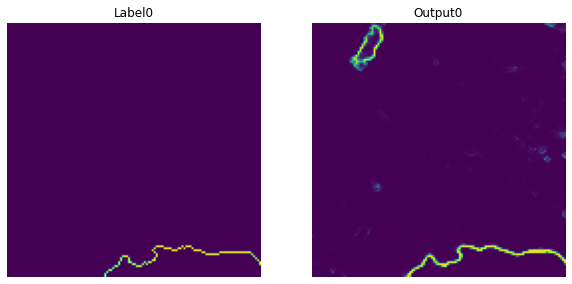

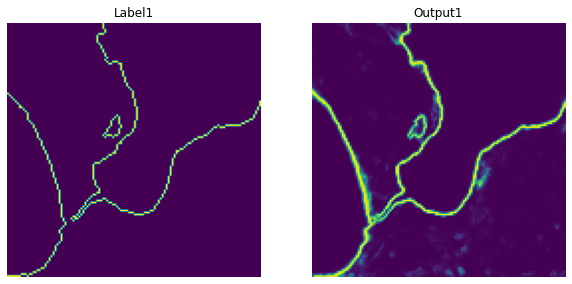

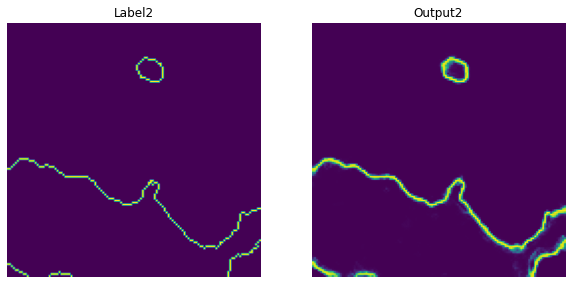

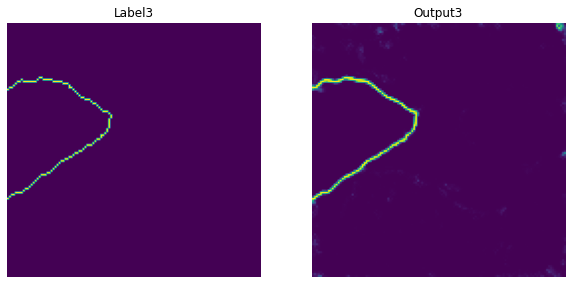

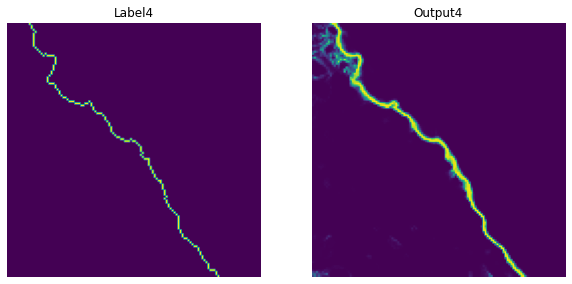

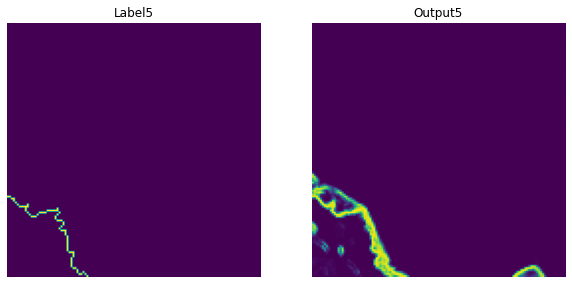

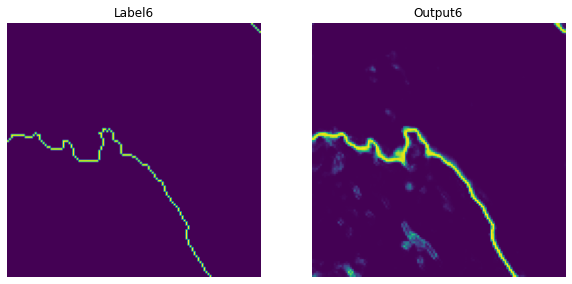

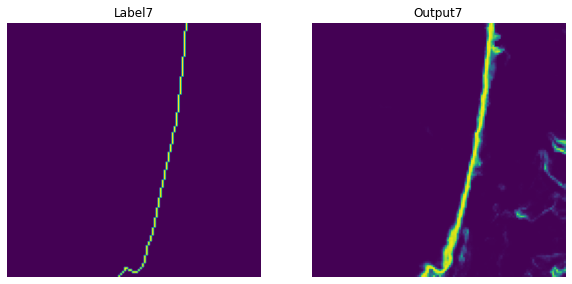

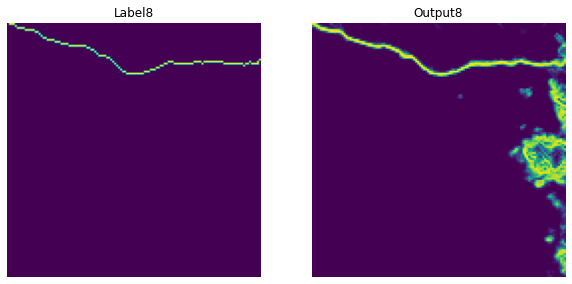

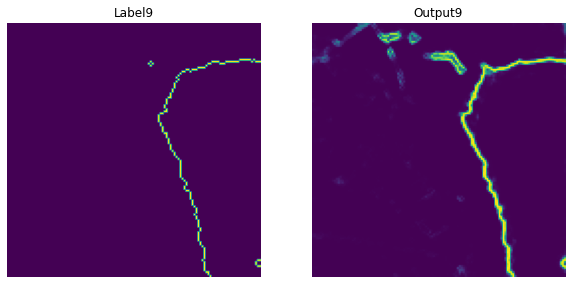

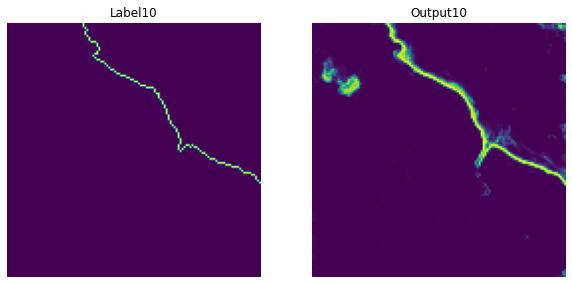

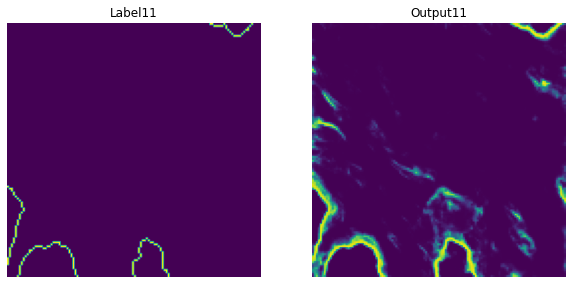

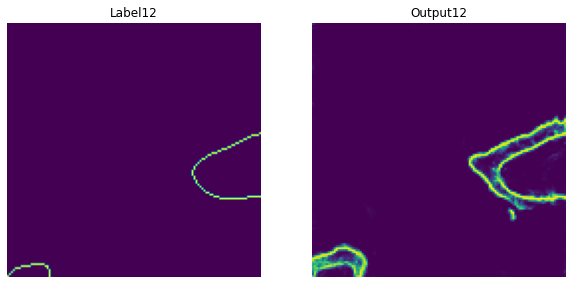

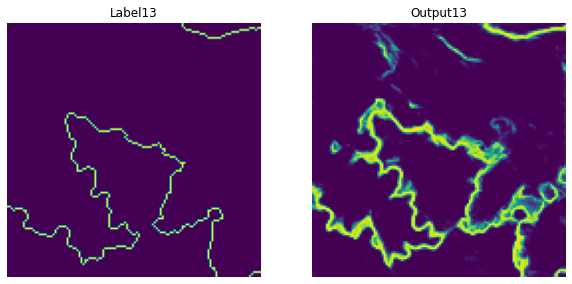

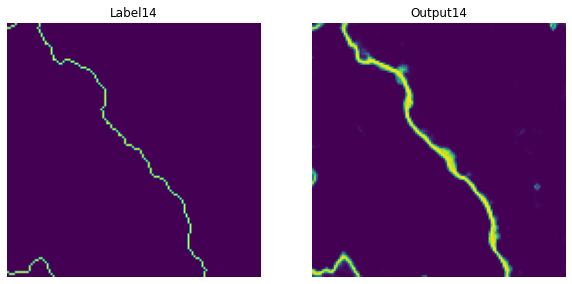

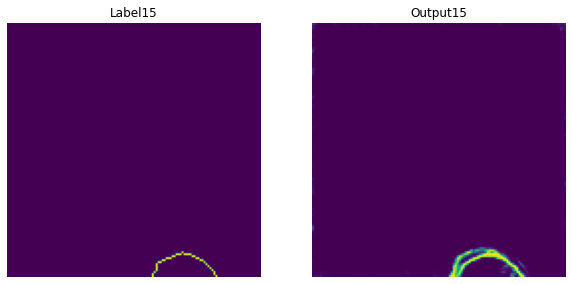

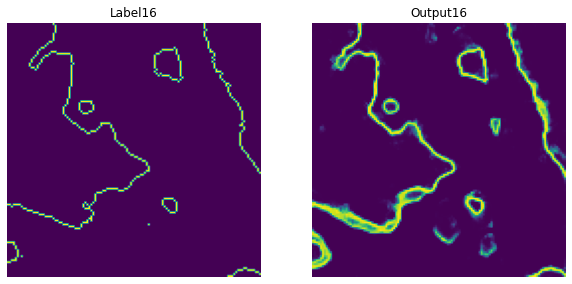

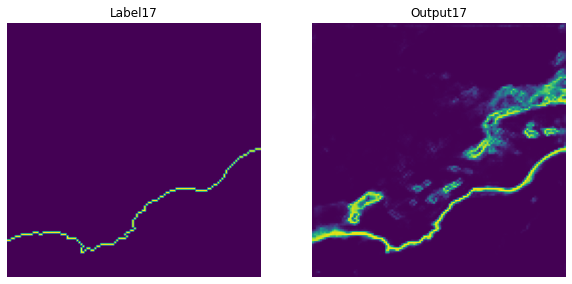

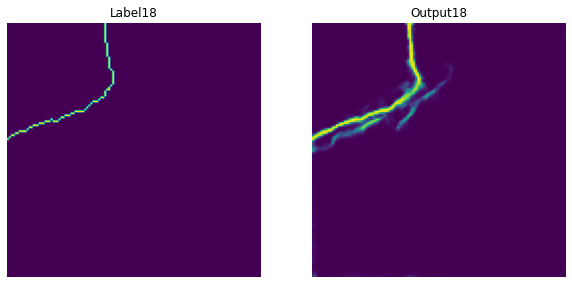

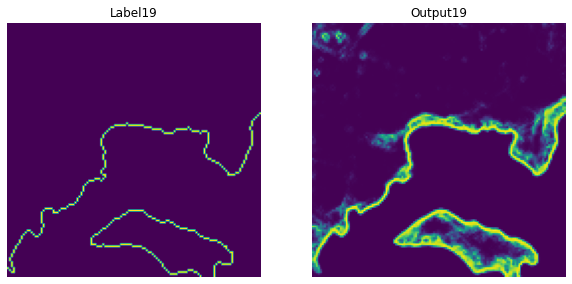

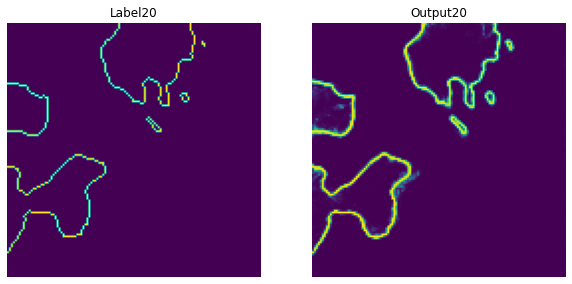

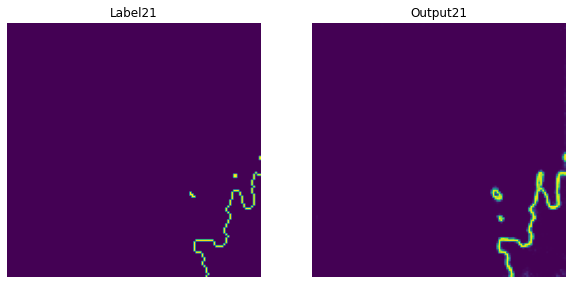

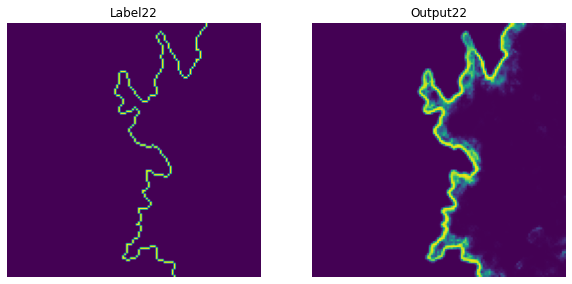

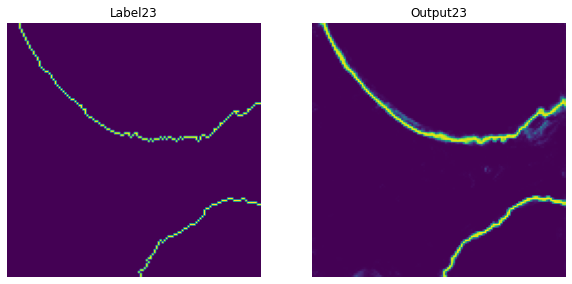

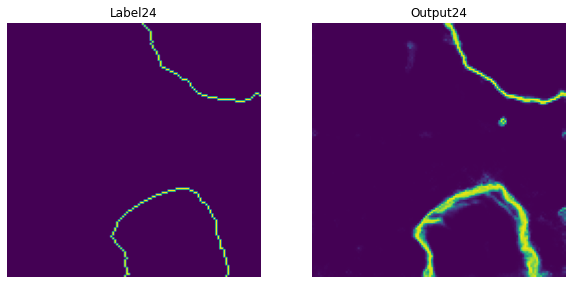

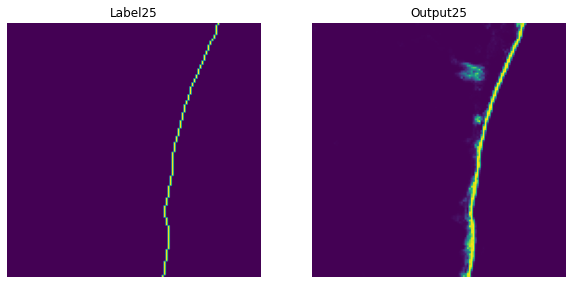

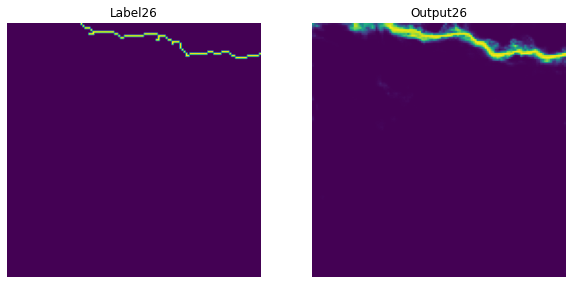

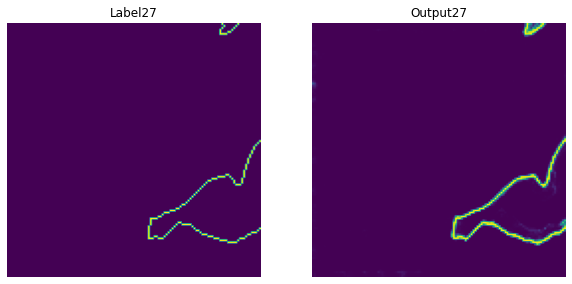

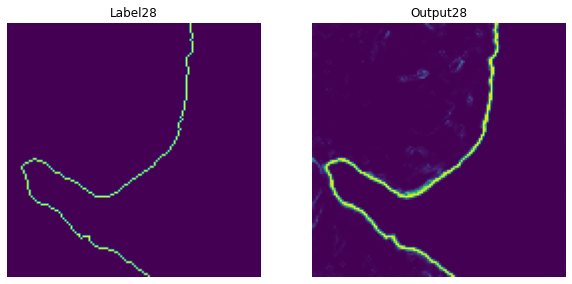

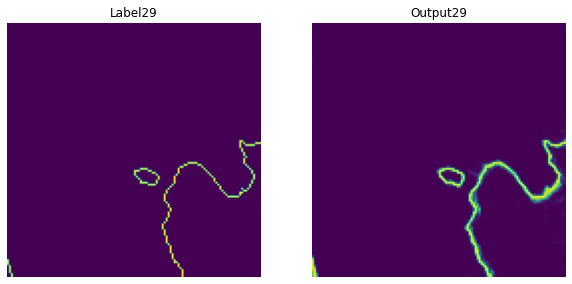

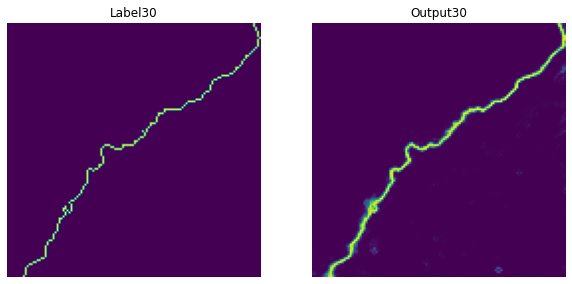

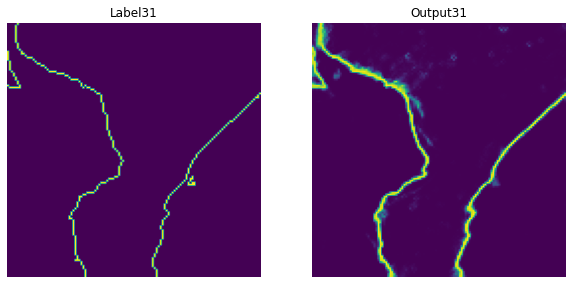

In [64]:
for i in range(32):
    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 1
    columns = 2

    # reading images
    

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)

    # showing image
    plt.imshow(Y[i,1,:,:])
    plt.axis('off')
    plt.title(f"Label{i}")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.imshow(out[i,1,:,:].cpu().detach().numpy())
    plt.axis('off')
    plt.title(f"Output{i}")
    
    print(f"f1Score{i}",f1_score(out[i,1,:,:], Y[i,1,:,:].to(device)))

In [72]:
def test(model, dataloaders, loss_fn, acc_fn, random_state=49, epochs=1):
    
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    model.eval()
    
    counter=0
    #train_loss,
    test_loss = []                         #Running training and validation loss
    loss_epoch, f1_epoch = [0],[0]
    AP_epoch =[0]
    loss_list = []
    times     = []
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch}')
        #print(scheduler.get_last_lr())
    

 ################ MODEL TESTING  #############################

        dataloader = dataloaders['test']         #get the training data
        step = 0
        loss_test = []
        f1=[]
        AP = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                x, y = inputs.to(device), labels.to(device)
                outputs= model(x)                                      
                

                #################Metrics###################
                f1.append(acc_fn(outputs[:,1:2,...], y[:,1:2,...]).cpu().detach().numpy())
                
                AP.append(average_precision_score(y[:,1:2,...].reshape(-1).cpu().detach().numpy(),  outputs[:,1:2,...].reshape(-1).cpu().detach().numpy()))
                

                B,C,H,W = y.shape
                ysum_zeros = y.sum(axis=(2,3))
                minimals =  0.000001* torch.ones_like(ysum_zeros)
                ysum = torch.where(ysum_zeros > 0.0, ysum_zeros.float(),minimals)
                weights = H*W/ysum
                weights /= weights.sum(axis=1).reshape(B,1)
                ce = -torch.log(outputs+0.000001)*y*weights.reshape(B,C,1,1)
                loss = ce.sum()/B/W/H
                
                loss_test.append(loss.cpu().detach().numpy())
                
                print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}', end='\r') 

                    
                test_loss.append(loss_test[-1])
                
                step+=1 
                
        loss_epoch.append(np.mean(loss_test))
        f1_epoch.append(np.mean(f1))
        AP_epoch.append(np.mean(AP))
        print()
        print()
        print(f' Loss test: {loss_epoch[-1]:.3f}, F-Score test:{f1_epoch[-1]:.3f}\n') 

In [73]:
#  step = 0
#         loss_test = []
#         f1=[]
#         AP = []
#         with torch.no_grad():
#             for inputs, labels in dataloader:
#                 x, y = inputs.to(device), labels.to(device)
# #                 print(y.shape)
#                 #optimizer.zero_grad()                                   # zero the gradients
#                 outputs= model(x)                                      #get model output for a given input
                
# #                 print(outputs.shape)
#                 #################Metrics###################
#                 f1.append(acc_fn(outputs, y).cpu().detach().numpy())
#                 AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))
#                 loss_test.append(loss_fn(outputs, y).cpu().detach().numpy())
#             ############################################
#                 print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}') 

#                 step+=1
#                 ##################Calculate Loss, backprop, and update###############
               
#                 test_loss.append(loss_test[-1])
#         loss_epoch.append(np.mean(loss_test))
#         f1_epoch.append(np.mean(f1))
#         AP_epoch.append(np.mean(AP))
#         print()
#         print()
#         print(f' Loss test: {loss_epoch[-1]:.3f}, F-Score test:{f1_epoch[-1]:.3f}\n') 

In [74]:
testModel = torch.load(r"C:\Saiful_Results\UNET_MC_2_Base_Full\Thu-Apr-27-12-27-12-2023\Epoch_048.pth")

In [75]:
test_history = test(testModel, dataloaders, loss_fn = border_loss, acc_fn = f1_score,epochs=1)

Epoch 0
Current step: 126, AllocMem (Mb): 5034.219, Loss: 0.014,  F1: 0.456,  AP: 0.552

 Loss test: 0.037, F-Score test:0.456



In [77]:
dataloaderSentinel = data(trans, trans_test, X_sen, Y_sen, X_val_sen, Y_val_sen, X_test_sen, Y_test_sen, batch_size=batch_size)


dataloaderLandSAT = data(trans, trans_test, X_LS, Y_LS, X_val_LandSAT, Y_val_LandSAT, X_test_LandSAT, Y_test_LandSAT, batch_size=batch_size)



Training:4608, Validation:513
Testing: 2053
Training:4500, Validation:500
Testing: 2000


In [78]:
test_Sen = test(testModel, dataloaderSentinel, loss_fn = border_loss, acc_fn = f1_score, epochs=1)

Epoch 0
Current step: 64, AllocMem (Mb): 5021.219, Loss: 0.010,  F1: 0.431,  AP: 0.404

 Loss test: 0.070, F-Score test:0.431



In [79]:
test_LS = test(testModel, dataloaderLandSAT, loss_fn = border_loss, acc_fn = f1_score, epochs=1)

Epoch 0
Current step: 62, AllocMem (Mb): 5030.469, Loss: 0.008,  F1: 0.482,  AP: 0.704

 Loss test: 0.004, F-Score test:0.482



In [76]:
#     return {'Train Loss':train_loss,
#             'Valid Loss':valid_loss,
#             'Times'     :times,
#             'Epochs': epoch}

In [ ]:
df = pd.DataFrame(history['f1_epoch'])
                  
df.to_csv(save_last+ '\\'+ "UNET_MC_2_Base_Full.csv")

In [ ]:
y = torch.randint(0,2,(1,3,128,128))

In [ ]:
outputs = torch.randint(0,2,(1,3,128,128))

In [ ]:
B,C,H,W = y.shape

weights = H*W/y.sum(axis=(2,3))
weights /= weights.sum(axis=1).reshape(B,1)
ce = -torch.log(outputs)*y*weights.reshape(B,C,1,1)
loss = ce.sum()/B/W/H

In [ ]:
loss

In [ ]:
y.sum(axis=(2,3))

In [ ]:
W

In [ ]:
B,C,H,W = y.shape



In [ ]:
weights = H*W/y.sum(axis=(2,3))


In [ ]:
weights

In [ ]:
weights /= weights.sum(axis=1).reshape(B,1)
weights

In [ ]:
ce = -torch.log(outputs+0.000001)*y*weights.reshape(B,C,1,1)
ce

In [ ]:
loss = ce.sum()/B/W/H

In [ ]:
loss
